In [1]:
import pandas as pd
import numpy as np
import random
import os
import itertools
import pickle
import ast
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from typing import List, Dict, Union
from pandas.api.types import is_numeric_dtype
from sklearn.cluster import DBSCAN, KMeans
from collections import Counter

pd.set_option('display.max_columns', None)

%matplotlib inline

SEED = 13210

np.random.seed(SEED)
random.seed(SEED)

In [2]:
DATA_SOURCE = [
    ('./data/filtered_data/preprocessed_data_Stage_database.csv', 'allceo'),
    ('./data/filtered_data/preprocessed_data_openpath_prod_durham.csv', 'durham'),
    ('./data/filtered_data/preprocessed_data_openpath_prod_mm_masscec.csv', 'masscec'),
    ('./data/filtered_data/preprocessed_data_openpath_prod_ride2own.csv', 'ride2own'),
    ('./data/filtered_data/preprocessed_data_openpath_prod_uprm_nicr.csv', 'nicr')
]

# Switch between 0-4
DB_NUMBER = 0

In [3]:
# Change this name to something unique
PATH = DATA_SOURCE[DB_NUMBER][0]
CURRENT_DB = DATA_SOURCE[DB_NUMBER][1]

df = pd.read_csv(PATH)

In [4]:
df.dropna(inplace=True)

not_needed = ['deprecatedID', 'data.key']

for col in not_needed:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

In [5]:
df.rename(
    columns={'end_local_dt_hour': 'end:hour', 'start_local_dt_hour': 'start:hour', 'replaced_mode': 'target'}, 
    inplace=True
)

In [6]:
TARGETS = ['p_micro', 'no_trip', 's_car', 'transit', 'car', 's_micro', 'ridehail', 'walk', 'unknown']
MAP = {ix+1: t for (ix, t) in enumerate(TARGETS)}
TARGET_MAP = {v:k for k, v in MAP.items()}

In [7]:
df.replace({'target': TARGET_MAP}, inplace=True)

In [8]:
# % of trips per mode.
trip_percents = df.groupby(['user_id'])['section_mode_argmax'].apply(lambda x: x.value_counts(normalize=True)).unstack(level=-1)
trip_percents.fillna(0., inplace=True)

trip_percents.columns = ['coverage_'+x for x in trip_percents.columns]

In [9]:
n_trips = pd.DataFrame(df.groupby('user_id').size(), columns=['n_trips'])

In [10]:
most_common_start = df.groupby('user_id')['start:hour'].apply(lambda x: x.value_counts().idxmax())

In [11]:
most_common_end = df.groupby('user_id')['end:hour'].apply(lambda x: x.value_counts().idxmax())

In [12]:
# % of distance in each primary sensed mode.
total_distance = df.groupby(['user_id', 'section_mode_argmax'])['section_distance_argmax'].sum().unstack(level=-1)
total_distance = total_distance.div(total_distance.sum(axis=1), axis=0)
total_distance.fillna(0., inplace=True)
total_distance.columns = ['pct_distance_' + x for x in total_distance.columns]

In [13]:
figure1_df = trip_percents.merge(right=total_distance, left_index=True, right_index=True).merge(
   right=n_trips, left_index=True, right_index=True
).merge(
   right=most_common_start, left_index=True, right_index=True
).merge(right=most_common_end, left_index=True, right_index=True)

In [14]:
# Normalize the last three columns.

def min_max_normalize(col: pd.Series):
    _max, _min = col.max(), col.min()
    return pd.Series((col - _min)/(_max - _min))

figure1_df['n_trips'] = min_max_normalize(figure1_df['n_trips'])
figure1_df['start:hour'] = np.sin(figure1_df['start:hour'].values)
figure1_df['end:hour'] = np.sin(figure1_df['end:hour'].values)

In [15]:
figure1_df.head()

,coverage_bicycling,coverage_car,coverage_transit,coverage_unknown,coverage_walking,pct_distance_bicycling,pct_distance_car,pct_distance_transit,pct_distance_unknown,pct_distance_walking,n_trips,start:hour,end:hour
user_id,,,,,,,,,,,,,
0600d3df-c1aa-4ca2-83f2-1f6b8931280d,0.050000,0.850000,0.0,0.000000,0.100000,0.009282,0.984954,0.0,0.000000,0.005764,0.083333,0.412118,0.650288
44eda4da-9223-4bb0-afd4-e7dd19fc6b27,0.065041,0.780488,0.0,0.065041,0.089431,0.038180,0.912693,0.0,0.033171,0.015957,0.743590,0.149877,0.149877
4c5436e9-4840-4872-9e8f-5d46ba81fe52,0.000000,0.714286,0.0,0.000000,0.285714,0.000000,0.847247,0.0,0.000000,0.152753,0.000000,0.650288,0.650288
7479810c-c602-4508-8ae2-da0bed87558d,0.116279,0.453488,0.0,0.127907,0.302326,0.015530,0.926489,0.0,0.027085,0.030896,0.506410,0.149877,0.990607
7f7c9d3b-84ed-4c14-be8a-aa256daaed01,0.017544,0.771930,0.0,0.035088,0.175439,0.005157,0.854327,0.0,0.110033,0.030483,0.320513,0.990607,0.990607


### Uncomment the following if you want to find the best eps.

In [16]:
# epsilons = np.linspace(1e-3, 1., 1000)

# best_eps = -np.inf
# best_score = -np.inf

# for eps in epsilons:
#     model = DBSCAN(eps=eps).fit(figure1_df)
    
#     if len(np.unique(model.labels_)) < 2:
#         continue
    
#     score = silhouette_score(figure1_df, model.labels_)
#     if score > best_score:
#         best_eps = eps
#         best_score = score

# print(best_eps)

In [17]:
'''
AlLCEO: eps=0.542
durham: eps=0.661
masscec: eps=0.64
'''

clustering = DBSCAN(eps=0.8).fit(figure1_df)

print(Counter(clustering.labels_))

Counter({0: 8, -1: 4})


4 users in cluster -1


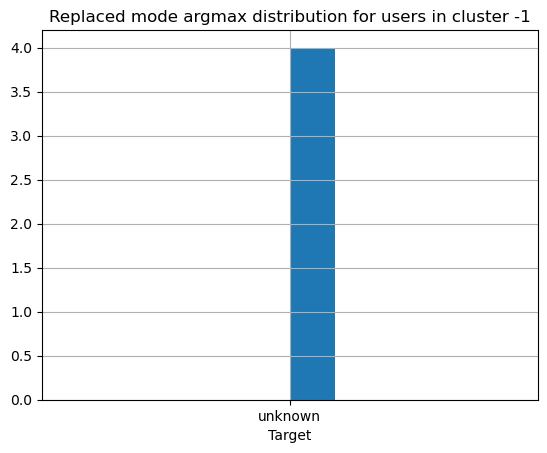

8 users in cluster 0


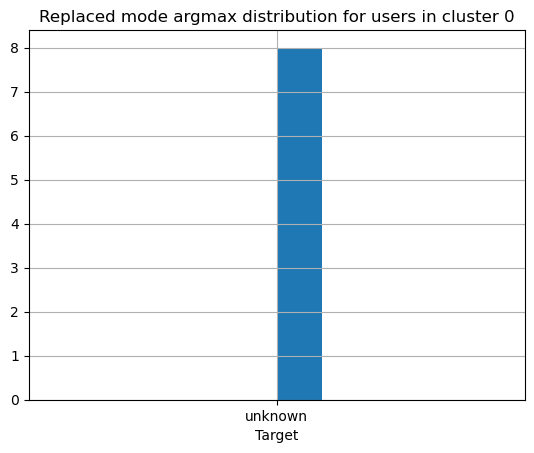

In [18]:
# After clustering, we would like to see what the replaced mode argmax distribution in each cluster is.

labels = clustering.labels_

for cix in np.unique(labels):
    cluster_users = figure1_df.iloc[labels == cix,:].index
    
    print(f"{len(cluster_users)} users in cluster {cix}")
    
    # Now, for each user, look at the actual data and determine the replaced mode argmax distribution.
    sub_df = df.loc[df.user_id.isin(cluster_users), :].reset_index(drop=True)
    
    sub_df['target'] =  sub_df['target'].apply(lambda x: MAP[x])
    
    rm_argmax = sub_df.groupby('user_id')['target'].apply(lambda x: x.value_counts().idxmax())
    fig, ax = plt.subplots()
    rm_argmax.hist(ax=ax)
    ax.set_title(f"Replaced mode argmax distribution for users in cluster {cix}")
    ax.set_xlabel("Target")
    
    plt.savefig(f'./outputs/{CURRENT_DB}__FIG1_cluster_{cix}_target_dist.png', dpi=300)
    
    plt.show()

In [19]:
user_target_pct = pd.DataFrame()

# For every user, compute the replaced mode distribution.
for user_id, user_data in df.groupby('user_id'):
    
    target_distribution = user_data['target'].value_counts(normalize=True)
    target_distribution.rename(index=MAP, inplace=True)
    user_target_pct = pd.concat([user_target_pct, target_distribution.to_frame(user_id).T])

In [20]:
user_target_pct.columns = ['pct_trips_' + str(x) for x in user_target_pct.columns]

In [21]:
target_distance = pd.DataFrame()

# For every user, compute the replaced mode distribution.
for user_id, user_data in df.groupby('user_id'):
    
    # total_distance = user_data['distance'].sum()
    distance_per_target = user_data.groupby('target')['section_distance_argmax'].sum()
    distance_per_target.rename(index=MAP, inplace=True)
    row = distance_per_target.to_frame(user_id).T
    target_distance = pd.concat([target_distance, row])
    
target_distance.columns = ['distance_' + str(x) for x in target_distance.columns]

In [22]:
target_duration = df.groupby(['user_id', 'target'])['section_duration_argmax'].sum().unstack()
target_duration.rename(columns=MAP, inplace=True)
target_duration.fillna(0., inplace=True)
target_duration.columns = ['duration_' + str(x) for x in target_duration.columns]

In [23]:
target_df = user_target_pct.merge(right=target_distance, left_index=True, right_index=True).merge(
    right=target_duration, left_index=True, right_index=True
)

target_df.fillna(0., inplace=True)

target_df = pd.DataFrame(
    MinMaxScaler().fit_transform(target_df),
    columns=target_df.columns,
    index=target_df.index
)

display(target_df)

,pct_trips_unknown,pct_trips_car,distance_unknown,distance_car,duration_car,duration_unknown
0600d3df-c1aa-4ca2-83f2-1f6b8931280d,1.0,0.0,0.166978,0.0,0.0,0.031289
44eda4da-9223-4bb0-afd4-e7dd19fc6b27,1.0,0.0,0.376308,0.0,0.0,0.362037
4c5436e9-4840-4872-9e8f-5d46ba81fe52,1.0,0.0,0.000000,0.0,0.0,0.000000
7479810c-c602-4508-8ae2-da0bed87558d,1.0,0.0,0.802132,0.0,0.0,0.447344
7f7c9d3b-84ed-4c14-be8a-aa256daaed01,1.0,0.0,0.209320,0.0,0.0,0.172709
892088f9-4a27-4f39-91fb-0f5e48d18982,1.0,0.0,0.982519,0.0,0.0,0.705049
993af3be-5011-44ad-b9cd-d4df7f0e67ad,1.0,0.0,0.659389,0.0,0.0,1.000000
c8158323-957d-43c7-bde6-193b99ee72b5,1.0,0.0,0.100448,0.0,0.0,0.030035
cbed6b7b-555d-43a0-aadc-4a42540a024e,1.0,0.0,0.373610,0.0,0.0,0.228214
de83c290-7708-4f8b-8ca3-656072164ef6,0.0,1.0,0.535949,1.0,1.0,0.700681


### Uncomment if you want to find the best eps

In [24]:
# epsilons = np.linspace(5e-3, 1., 1500)
# best_score = -np.inf
# best_eps = None
# best_n = None
# # alpha = 0.7
# beta = 0.05

# for eps in epsilons:
#     for n in range(2, 30):
#         labels = DBSCAN(eps=eps, min_samples=n).fit(target_df).labels_
    
#         n_unique = np.unique(labels)
#         n_outliers = len(labels[labels == -1])
        
#         if n_outliers == len(labels) or len(n_unique) < 2:
#             continue
    
#         # Encourage more clustering and discourage more outliers.
#         score = silhouette_score(target_df, labels) + (len(labels) - n_outliers)/n_outliers
        
#         if score > best_score:
#             best_score = score
#             best_eps = eps
#             best_n = n

# print(f"{best_score=}, {best_n=}, {best_eps=}")

In [25]:
# 0.35 is a good value

'''
allCEO = DBSCAN(eps=0.52, min_samples=2)
durham: DBSCAN(eps=best_eps, min_samples=2)
masscec: min_samples=2, eps=0.986724482988659
'''

cl2 = DBSCAN(eps=0.6, min_samples=2).fit(target_df)
# cl2 = KMeans(n_clusters=5).fit(target_df)

Counter(cl2.labels_)

Counter({0: 11, -1: 1})

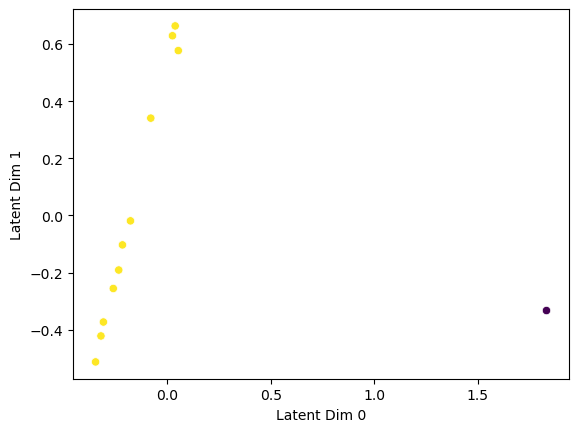

In [26]:
from sklearn.decomposition import PCA

tsfm = PCA(n_components=2).fit_transform(target_df)

fig, ax = plt.subplots()
sns.scatterplot(x=tsfm[:,0], y=tsfm[:,1], c=cl2.labels_)
ax.set(xlabel='Latent Dim 0', ylabel='Latent Dim 1')
plt.savefig(f'./outputs/{CURRENT_DB}__Fig2__PCA_w_colors.png', dpi=300)
plt.show()

In [27]:
print(df.columns.tolist())

['duration', 'distance', 'start:hour', 'end:hour', 'user_id', 'target', 'section_mode_argmax', 'section_distance_argmax', 'section_duration_argmax', 'is_student', 'is_paid', 'has_drivers_license', 'n_residents_u18', 'n_residence_members', 'income_category', 'available_modes', 'n_residents_with_license', 'n_working_residents', 'n_motor_vehicles', 'has_medical_condition', 'ft_job', 'multiple_jobs', 'highest_education_bachelor_s_degree', 'highest_education_high_school_graduate_or_ged', 'highest_education_prefer_not_to_say', 'highest_education_some_college_or_associates_degree', 'primary_job_description_Clerical or administrative support', 'primary_job_description_Other', 'gender_man', 'gender_woman', 'age_16___20_years_old', 'age_21___25_years_old', 'age_26___30_years_old', 'av_ridehail', 'av_p_micro', 'av_walk', 'av_transit', 'av_car', 'av_s_micro', 'av_s_car', 'av_unknown', 'av_no_trip', 'cost_ridehail', 'cost_p_micro', 'cost_walk', 'cost_transit', 'cost_car', 'cost_s_micro', 'cost_s_ca

In [28]:
# Per-cluster users.
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier


demographic_cols = {
    'allceo': [
            'has_drivers_license', 'is_student', 'is_paid', 'income_category',
            'n_residence_members', 'n_residents_u18', 'n_residents_with_license',
            'n_motor_vehicles', 'has_medical_condition',
            'ft_job', 'multiple_jobs', 'n_working_residents',
            "highest_education_Bachelor's degree",
            'highest_education_Graduate degree or professional degree',
            'highest_education_High school graduate or GED',
            'highest_education_Less than a high school graduate',
            'highest_education_Prefer not to say',
            'highest_education_Some college or associates degree',
            'primary_job_description_Clerical or administrative support',
            'primary_job_description_Custodial',
            'primary_job_description_Education',
            'primary_job_description_Food service',
            'primary_job_description_Linecook',
            'primary_job_description_Manufacturing, construction, maintenance, or farming',
            'primary_job_description_Medical/healthcare',
            'primary_job_description_Non-profit program manager',
            'primary_job_description_Other',
            'primary_job_description_Professional, managerial, or technical',
            'primary_job_description_Sales or service',
            'primary_job_description_Self employed',
            'primary_job_description_food service', 'gender_Man',
            'gender_Nonbinary/genderqueer/genderfluid', 'gender_Prefer not to say',
            'gender_Woman', 'gender_Woman;Nonbinary/genderqueer/genderfluid',
            'age_16___20_years_old', 'age_21___25_years_old',
            'age_26___30_years_old', 'age_31___35_years_old',
            'age_36___40_years_old', 'age_41___45_years_old',
            'age_46___50_years_old', 'age_51___55_years_old',
            'age_56___60_years_old', 'age_61___65_years_old', 'age___65_years_old',
            'av_transit', 'av_no_trip', 'av_p_micro', 'av_s_micro', 'av_ridehail',
            'av_unknown', 'av_walk', 'av_car', 'av_s_car'
        ],
        'durham': [
            'is_student', 'is_paid', 'has_drivers_license', 'n_residents_u18',
            'n_residence_members', 'income_category',
            'n_residents_with_license', 'n_working_residents', 'n_motor_vehicles',
            'has_medical_condition', 'ft_job', 'multiple_jobs',
            'highest_education_bachelor_s_degree',
            'highest_education_graduate_degree_or_professional_degree',
            'highest_education_high_school_graduate_or_ged',
            'highest_education_less_than_a_high_school_graduate',
            'highest_education_some_college_or_associates_degree',
            'primary_job_description_Clerical or administrative support',
            'primary_job_description_Manufacturing, construction, maintenance, or farming',
            'primary_job_description_Other',
            'primary_job_description_Professional, Manegerial, or Technical',
            'primary_job_description_Sales or service', 'gender_man',
            'gender_non_binary_genderqueer_gender_non_confor', 'gender_woman',
            'age_16___20_years_old', 'age_21___25_years_old',
            'age_26___30_years_old', 'age_31___35_years_old',
            'age_36___40_years_old', 'age_41___45_years_old',
            'age_51___55_years_old', 'age_56___60_years_old', 'av_walk',
            'av_unknown', 'av_no_trip', 'av_p_micro', 'av_transit', 'av_car',
            'av_ridehail', 'av_s_micro', 'av_s_car'
        ],
        'nicr': [
            'is_student', 'is_paid',
            'has_drivers_license', 'n_residents_u18', 'n_residence_members',
            'income_category', 'n_residents_with_license',
            'n_working_residents', 'n_motor_vehicles', 'has_medical_condition',
            'ft_job', 'multiple_jobs',
            'highest_education_high_school_graduate_or_ged',
            'highest_education_prefer_not_to_say', 'primary_job_description_Other',
            'gender_man', 'gender_woman', 'age_16___20_years_old', 'av_p_micro',
            'av_car', 'av_transit', 'av_ridehail', 'av_no_trip', 'av_s_car',
            'av_s_micro', 'av_unknown', 'av_walk'
        ],
        'masscec': [
            'is_student', 'is_paid',
            'has_drivers_license', 'n_residents_u18', 'n_residence_members',
            'income_category', 'n_residents_with_license',
            'n_working_residents', 'n_motor_vehicles', 'has_medical_condition',
            'ft_job', 'multiple_jobs', 'highest_education_bachelor_s_degree',
            'highest_education_graduate_degree_or_professional_degree',
            'highest_education_high_school_graduate_or_ged',
            'highest_education_less_than_a_high_school_graduate',
            'highest_education_prefer_not_to_say',
            'highest_education_some_college_or_associates_degree',
            'primary_job_description_Clerical or administrative support',
            'primary_job_description_Manufacturing, construction, maintenance, or farming',
            'primary_job_description_Other',
            'primary_job_description_Prefer not to say',
            'primary_job_description_Professional, Manegerial, or Technical',
            'primary_job_description_Sales or service', 'gender_man',
            'gender_prefer_not_to_say', 'gender_woman', 'age_16___20_years_old',
            'age_21___25_years_old', 'age_26___30_years_old',
            'age_31___35_years_old', 'age_36___40_years_old',
            'age_41___45_years_old', 'age_46___50_years_old',
            'age_51___55_years_old', 'age_56___60_years_old',
            'age_61___65_years_old', 'age___65_years_old', 'av_p_micro', 'av_s_car',
            'av_s_micro', 'av_transit', 'av_car', 'av_no_trip', 'av_unknown',
            'av_ridehail', 'av_walk'
        ],
        'ride2own': [
            'has_drivers_license', 'is_student',
            'is_paid', 'income_category', 'n_residence_members',
            'n_working_residents', 'n_residents_u18', 'n_residents_with_license',
            'n_motor_vehicles', 'has_medical_condition',
            'ft_job', 'multiple_jobs',
            'highest_education_bachelor_s_degree',
            'highest_education_high_school_graduate_or_ged',
            'highest_education_less_than_a_high_school_graduate',
            'highest_education_some_college_or_associates_degree',
            'primary_job_description_Other',
            'primary_job_description_Professional, Manegerial, or Technical',
            'gender_man', 'gender_woman', 'age_31___35_years_old',
            'age_36___40_years_old', 'age_41___45_years_old',
            'age_51___55_years_old', 'av_no_trip', 'av_s_micro', 'av_transit',
            'av_car', 'av_ridehail', 'av_p_micro', 'av_s_car', 'av_walk',
            'av_unknown'
        ]
}


cluster_labels = cl2.labels_
demographics = df.groupby('user_id').first()[demographic_cols[CURRENT_DB]]
demographics = demographics.loc[target_df.index, :]

For cluster -1:


,feature,ch
0,is_student,-0.0
24,av_s_micro,-0.0
23,av_s_car,-0.0
22,av_no_trip,-0.0


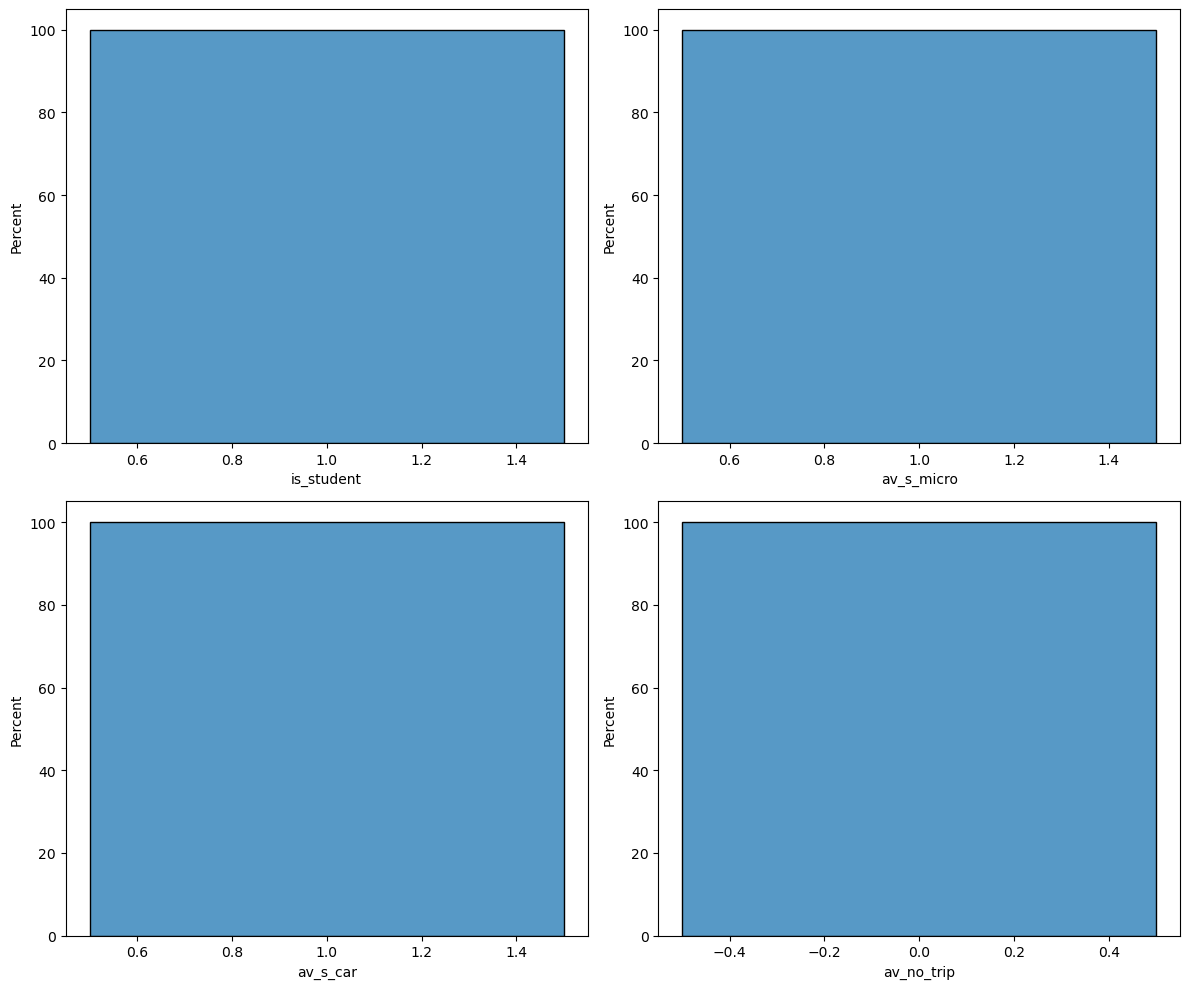


For cluster 0:


,feature,ch
0,is_student,-0.0
23,av_s_car,-0.0
22,av_no_trip,-0.0
21,av_ridehail,-0.0


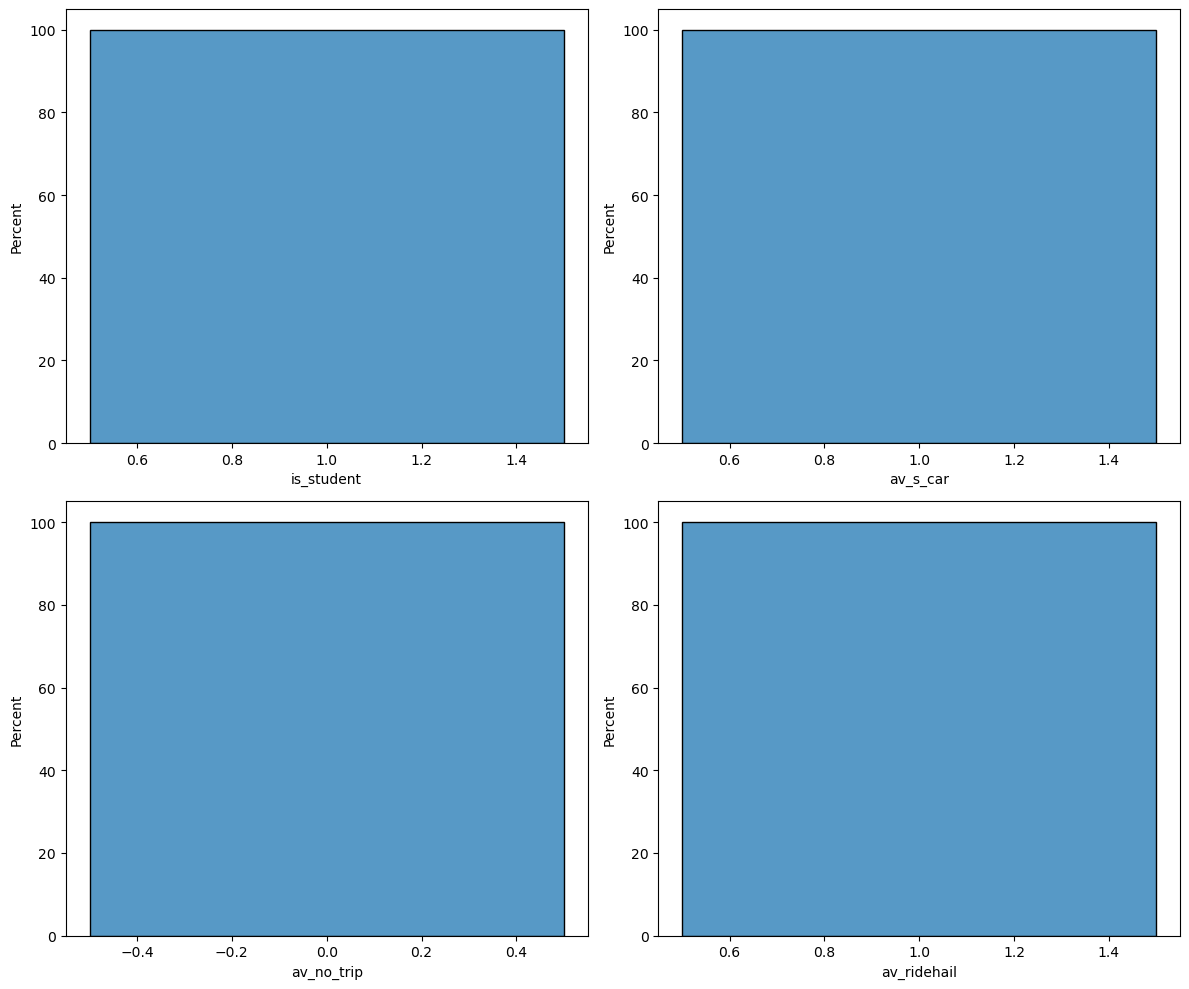

In [29]:
### DEMOGRAPHICS

def entropy(x):
    # Compute bincount, normalize over the entire size. Gives us probabilities.
    p = np.unique(x, return_counts=True)[1]/len(x)
    # Compute the enropy usnig the probabilities.
    return -np.sum(p * np.log2(p))

def preprocess_demo_data(df: pd.DataFrame):
    return df


within_cluster_homogeneity = dict()
other_cluster_homogeneity = dict()
labels = cl2.labels_

for cix in np.unique(labels):
    within_cluster_homogeneity[cix] = dict()
    users = target_df[labels == cix].index
    data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
    processed = preprocess_demo_data(data)
    
    for col in processed.columns:
        # Numeric/ordinal values. Use std. to measure homogeneity.
        if col in [
            'n_residence_members', 'n_residents_u18', 'n_working_residents', 'n_motor_vehicles',
            'n_residents_with_license', 'income_category'
        ]:
            within_cluster_homogeneity[cix][col] = processed[col].std()
        else:
            within_cluster_homogeneity[cix][col] = entropy(processed[col])

# Compute average homogeneity across other clusters.
for cix in within_cluster_homogeneity.keys():
    other_cluster_homogeneity[cix] = dict()
    other_clusters = set(within_cluster_homogeneity.keys()) - set([cix])
    for feature in within_cluster_homogeneity[cix].keys():
        homogeneity_in_others = [within_cluster_homogeneity[x][feature] for x in other_clusters]
        other_cluster_homogeneity[cix][feature] = np.mean(homogeneity_in_others)

        
# Compute contrastive homogeneity
# CH = homogeneity within cluster / average homogeneity across other clusters
for cix in within_cluster_homogeneity.keys():
    ch_scores = list()
    print(f"For cluster {cix}:")
    for feature in within_cluster_homogeneity[cix].keys():
        feature_ch = within_cluster_homogeneity[cix][feature]/(other_cluster_homogeneity[cix][feature] + 1e-6)
        ch_scores.append((feature, feature_ch))
    
    ch_df = pd.DataFrame(ch_scores, columns=['feature', 'ch']).sort_values(by=['ch']).head(4)
    
    # Display actual values.
    users = target_df[labels == cix].index
    data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
    processed = preprocess_demo_data(data)
    
    display(ch_df)
    print()
    filtered = processed.loc[:, processed.columns.isin(ch_df.feature)][ch_df.feature]
    filtered_features = ch_df.feature.tolist()
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    for i, a in enumerate(ax.flatten()):
        sns.histplot(filtered[filtered_features[i]], ax=a, stat="percent")
    plt.tight_layout()
    plt.savefig(f"{CURRENT_DB}_{cix}_Demographic_consistency.png", dpi=300)
    plt.show()
    print()

In [30]:
from scipy.stats import iqr

def get_trip_summary_df(users, df):
    '''
    Group the trips by user ID and argmax_mode and compute trip summaries. Additional
    statistics that could be incorporated: IQR.
    
    mode_coverage computes trips summaries for the sections with the most-traveled distance.
    '''
    
    costs = [c for c in df.columns if 'av_' in c]
    
    mode_coverage = df.groupby(['user_id', 'section_mode_argmax'])[
        ['section_duration_argmax', 'section_distance_argmax', 'mph'] + costs
    ].agg(['mean', 'median']).unstack()
    
    global_stats = df.groupby('user_id')[['duration', 'distance']].agg(
        ['mean', 'median']
    )

    mode_coverage.columns = mode_coverage.columns.map('_'.join)
    global_stats.columns = global_stats.columns.map('_'.join)
    
    # return mode_coverage
    return mode_coverage.merge(right=global_stats, left_index=True, right_index=True)

For cluster -1:


/var/folders/4x/l9lw50rn7qvf79m01f21x70mlpd6gh/T/ipykernel_35596/1105737326.py:49: RuntimeWarning: Mean of empty slice
  out_cluster_homogeneity[cix][feature] = np.nanmean([in_cluster_homogeneity[x].get(feature, np.nan) for x in oix])


unknown    0.986577
car        0.013423
Name: target, dtype: float64

,feature,ch
0,section_duration_argmax_mean_bicycling,0.0
25,duration_median,0.0
24,duration_mean,0.0
23,mph_median_walking,0.0


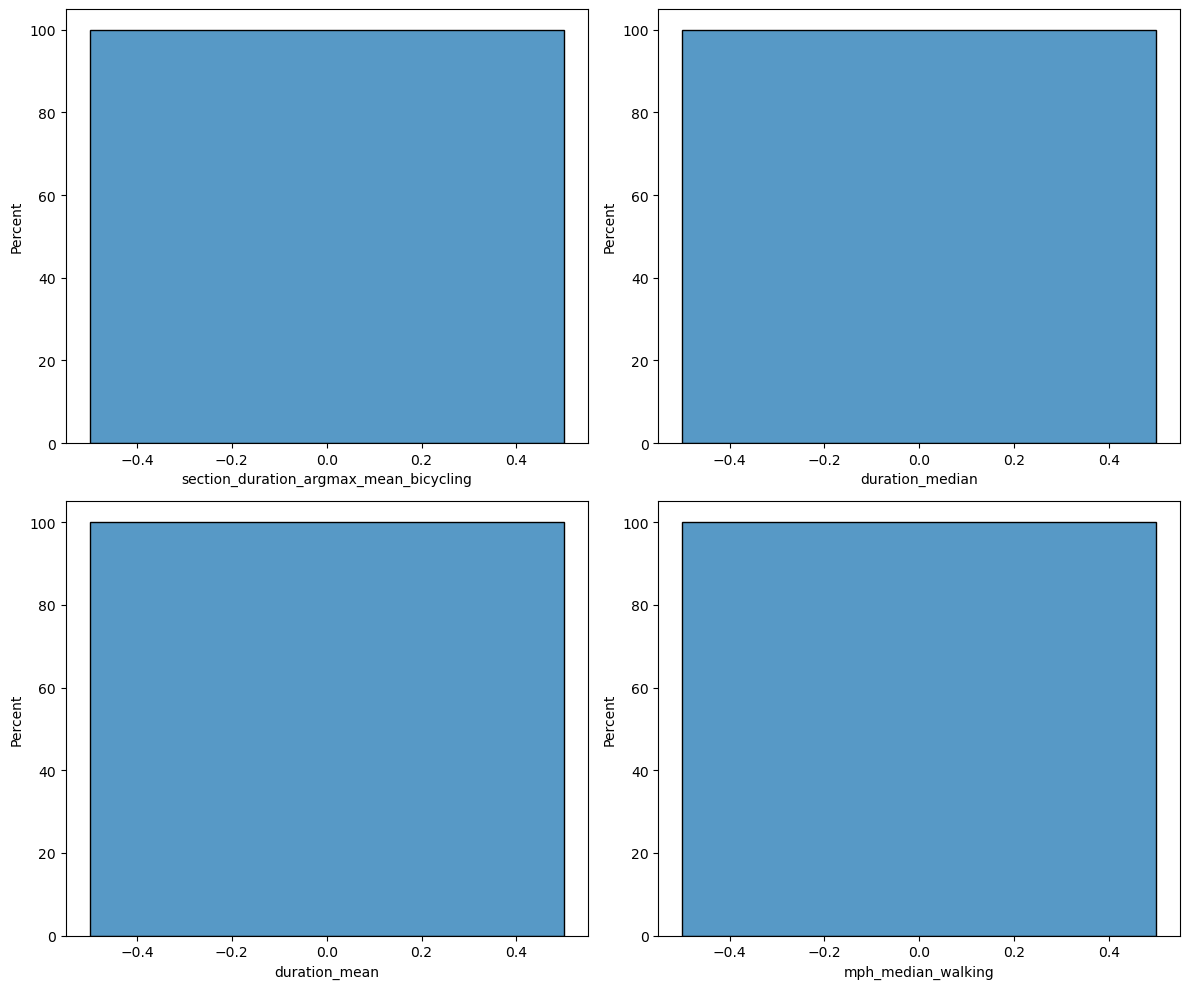


For cluster 0:


unknown    1.0
Name: target, dtype: float64

,feature,ch
31,duration_median,250175.825182
1,section_duration_argmax_mean_car,262552.009065
11,section_distance_argmax_mean_car,263103.437553
24,mph_mean_walking,264091.869648


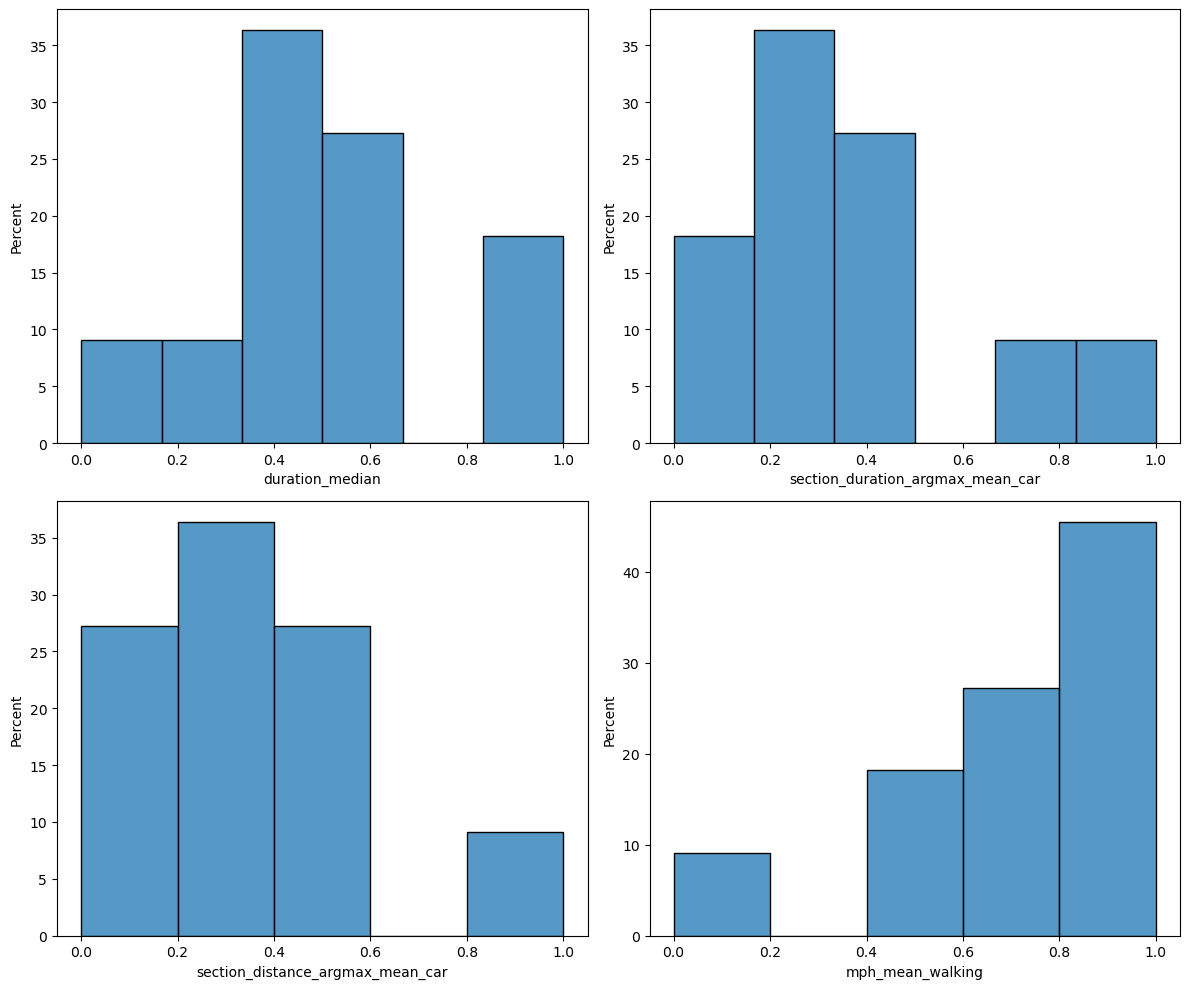

In [31]:
## TRIP SUMMARIES

# Per-cluster users.
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import SelectKBest, mutual_info_classif

labels = cl2.labels_

def get_data(cix):
    users = target_df.iloc[labels == cix, :].index
    
    # Compute trip summaries.
    X = df.loc[df.user_id.isin(users), [
        'section_distance_argmax', 'duration', 'distance', 'section_mode_argmax',
        'section_duration_argmax', 'mph', 'target', 'user_id'
    ] + [c for c in df.columns if 'cost_' in c]].reset_index(drop=True)
    
    # Compute the target distribution and select the argmax.
    target_distribution = X.target.value_counts(ascending=False, normalize=True)
    target_distribution.rename(index=MAP, inplace=True)
    
    # Caution - this summary df has NaNs. Use nanstd() to compute nan-aware std.
    subset = get_trip_summary_df(users, X)
    
    norm_subset = pd.DataFrame(
        MinMaxScaler().fit_transform(subset),
        columns=subset.columns, index=subset.index
    )
    
    return norm_subset, target_distribution


in_cluster_homogeneity = dict()
out_cluster_homogeneity = dict()

for cluster_ix in np.unique(labels):
    in_cluster_homogeneity[cluster_ix] = dict()
    norm_subset, _ = get_data(cluster_ix)
    for feature in norm_subset.columns:
        in_cluster_homogeneity[cluster_ix][feature] = np.nanstd(norm_subset[feature])

for cix in in_cluster_homogeneity.keys():
    out_cluster_homogeneity[cix] = dict()
    oix = set(labels) - set([cix])
    for feature in norm_subset.columns:
        out_cluster_homogeneity[cix][feature] = np.nanmean([in_cluster_homogeneity[x].get(feature, np.nan) for x in oix])

# Now, compute the per-cluster homogeneity.
for cix in in_cluster_homogeneity.keys():
    ch = list()
    for feature in in_cluster_homogeneity[cix].keys():
        if feature in in_cluster_homogeneity[cix] and feature in out_cluster_homogeneity[cix]:
            ratio = in_cluster_homogeneity[cix][feature] / (out_cluster_homogeneity[cix][feature] + 1e-6)
        ch.append([feature, ratio])
    
    ch_df = pd.DataFrame(ch, columns=['feature', 'ch']).sort_values(by=['ch']).head(4)
    data, target_dist = get_data(cix)
    
    features = ch_df.feature.tolist()
    
    print(f"For cluster {cix}:")
    display(target_dist)
    display(ch_df)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    for i, a in enumerate(ax.flatten()):
        sns.histplot(data[features[i]], ax=a, stat="percent")
    plt.tight_layout()
    plt.savefig(f"{CURRENT_DB}_{cix}_Trip_consistency.png", dpi=300)
    plt.show()
    print()
    
    print(50*'=')

## Now check the combined homogeneity score

For cluster -1:


/var/folders/4x/l9lw50rn7qvf79m01f21x70mlpd6gh/T/ipykernel_35596/2042025115.py:34: RuntimeWarning: Mean of empty slice
  oc[cix][feature] = np.nanmean([ic[x].get(feature, np.nan) for x in oix])


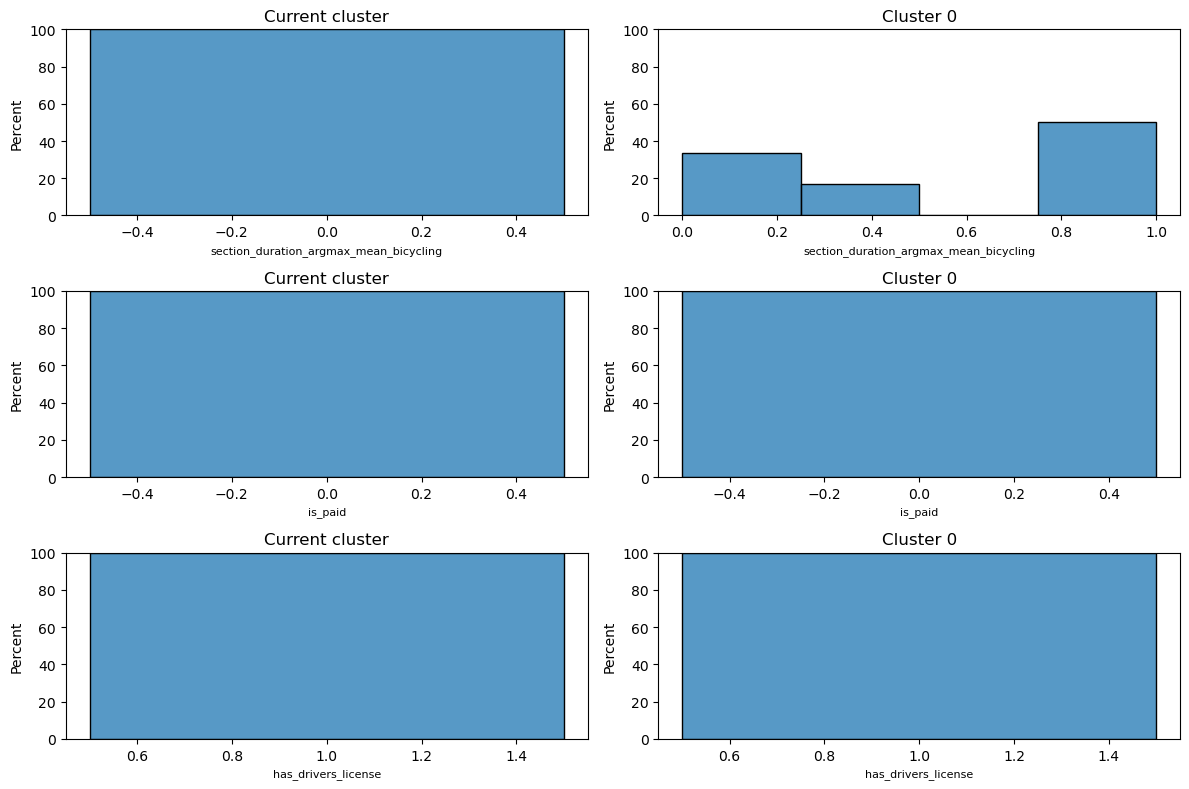

For cluster 0:


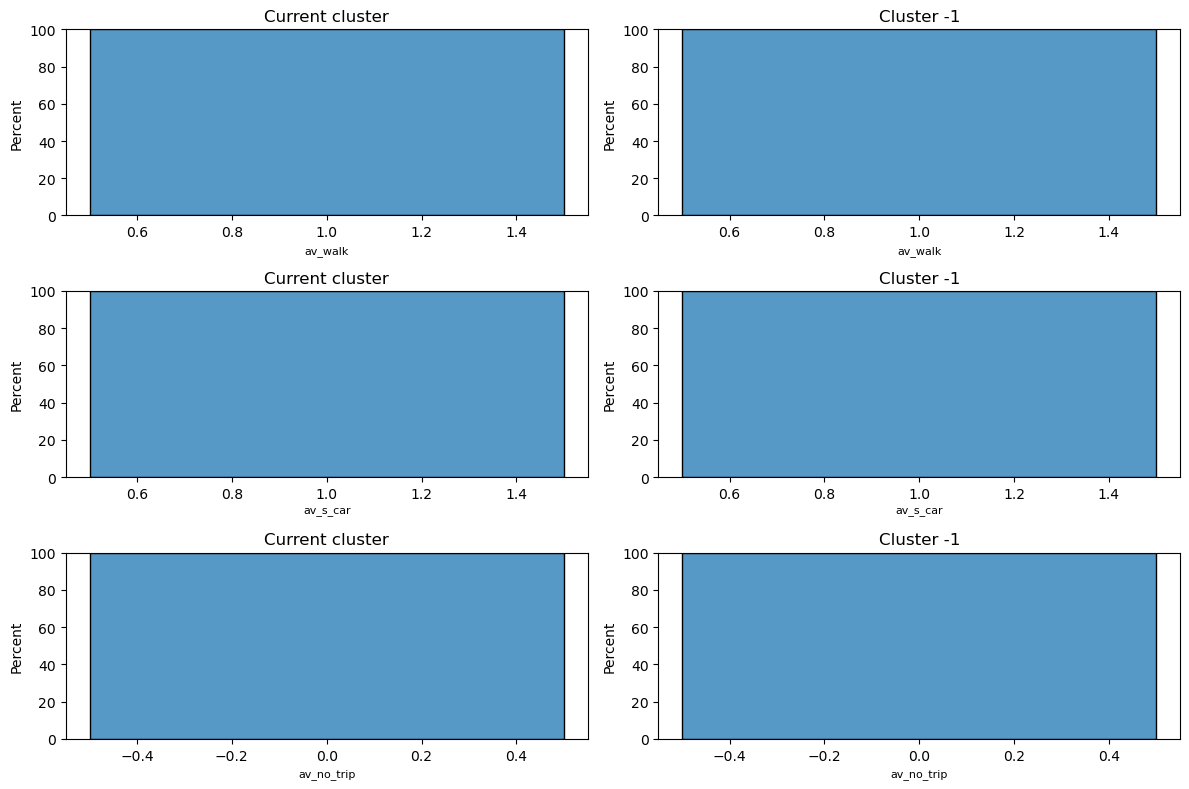

In [32]:
ic, oc = dict(), dict()

labels = cl2.labels_
TOP_K = 3


for cix in np.unique(labels):
    ic[cix] = dict()
    
    # Trip characteristics.
    norm_subset, _ = get_data(cix)
    for feature in norm_subset.columns:
        ic[cix][feature] = np.nanstd(norm_subset[feature])
    
    # Demographics.
    users = target_df[labels == cix].index
    data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
    processed = preprocess_demo_data(data)
    
    for col in processed.columns:
        # Numeric/ordinal values. Use std. to measure homogeneity.
        if col in [
            'n_residence_members', 'n_residents_u18', 'n_working_residents', 'n_motor_vehicles',
            'n_residents_with_license', 'income_category'
        ]:
            ic[cix][col] = np.nanstd(processed[col])
        else:
            ic[cix][col] = entropy(processed[col])

for cix in ic.keys():
    oc[cix] = dict()
    oix = set(labels) - set([cix])
    for feature in ic[cix].keys():
        oc[cix][feature] = np.nanmean([ic[x].get(feature, np.nan) for x in oix])

per_cluster_most_homogeneous = dict()

# Now, compute the per-cluster homogeneity.
ax_ix = 0
for cix in ic.keys():

    print(f"For cluster {cix}:")

    # For each, cluster, we will have (TOP_K x n_clusters) figures.
    fig, ax = plt.subplots(nrows=TOP_K, ncols=len(ic.keys()), figsize=(12, 8))

    other_ix = set(ic.keys()) - set([cix])
    
    ch = list()
    for feature in ic[cix].keys():
        if feature in oc[cix]:
            ratio = ic[cix][feature] / (oc[cix][feature] + 1e-6)
        ch.append([feature, ratio])
    
    # Just the top k.
    ch_df = pd.DataFrame(ch, columns=['feature', 'ch']).sort_values(by=['ch']).reset_index(drop=True).head(TOP_K)

    figure_data = dict()
    
    # Get the actual trip summary data.
    trip_summary_data, target_dist = get_data(cix)
    
    # Get the actual demographic data.
    users = target_df[labels == cix].index
    data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
    processed = preprocess_demo_data(data)

    # Left-most subplot will be that of the current cluster's feature.
    for row_ix, row in ch_df.iterrows():
        if row.feature in trip_summary_data.columns:
            sns.histplot(trip_summary_data[row.feature], ax=ax[row_ix][0], stat='percent').set_title("Current cluster")
        else:
            sns.histplot(processed[row.feature], ax=ax[row_ix][0], stat='percent').set_title("Current cluster")
        ax[row_ix][0].set_xlabel(ax[row_ix][0].get_xlabel(), fontsize=8)
        ax[row_ix][0].set_ylim(0., 100.)

    offset_col_ix = 1
    ## Now, others.
    for oix in other_ix:
        # Get the actual trip summary data.
        other_summary_data, _ = get_data(oix)
        
        # Get the actual demographic data.
        users = target_df[labels == oix].index
        data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
        other_demo = preprocess_demo_data(data)

        for row_ix, row in ch_df.iterrows():
            if row.feature in other_summary_data.columns:
                sns.histplot(other_summary_data[row.feature], ax=ax[row_ix][offset_col_ix], stat='percent').set_title(f"Cluster {oix}")
            else:
                sns.histplot(other_demo[row.feature], ax=ax[row_ix][offset_col_ix], stat='percent').set_title(f"Cluster {oix}")
            ax[row_ix][offset_col_ix].set_xlabel(ax[row_ix][offset_col_ix].get_xlabel(), fontsize=8)
            ax[row_ix][offset_col_ix].set_ylim(0., 100.)
            
        offset_col_ix += 1
    
    plt.tight_layout()
    plt.savefig(f"./outputs/{CURRENT_DB}_cluster{cix}_combined_features.png", dpi=300)
    plt.show()
    print(50 * '=')

## Try a different clustering technique? (Unexplored)

In [33]:
# from sklearn.cluster import AffinityPropagation

# best_score = -np.inf
# best_params = None

In [34]:
# cls = AffinityPropagation(random_state=13210).fit(target_df)
# labels = cls.labels_

# print(labels)

In [35]:
# center_embeddings = cls.cluster_centers_
# centers_proj = PCA(n_components=2).fit_transform(center_embeddings)

In [36]:
# fig, ax = plt.subplots()
# sns.scatterplot(x=tsfm[:,0], y=tsfm[:,1], c=cls.labels_, ax=ax)
# ax.scatter(x=centers_proj[:,0], y=centers_proj[:,1], marker='X', c='red', alpha=0.5)
# ax.set(xlabel='Latent Dim 0', ylabel='Latent Dim 1')
# # plt.legend([str(x) for x in ap_labels], loc='best')
# plt.show()

In [37]:
# def get_data2(cix, labels):
#     users = target_df.iloc[labels == cix, :].index
    
#     # Compute trip summaries.
#     X = df.loc[df.user_id.isin(users), [
#         'section_distance_argmax', 'section_duration_argmax',
#         'section_mode_argmax', 'distance',
#         'duration', 'mph', 'user_id', 'target'
#     ]]
    
#     # Compute the target distribution and select the argmax.
#     target_distribution = X.target.value_counts(ascending=False, normalize=True)
#     target_distribution.rename(index=MAP, inplace=True)
    
#     # Caution - this summary df has NaNs. Use nanstd() to compute nan-aware std.
#     subset = get_trip_summary_df(users, X)
    
#     norm_subset = pd.DataFrame(
#         MinMaxScaler().fit_transform(subset),
#         columns=subset.columns, index=subset.index
#     )
    
#     return norm_subset, target_distribution

In [38]:
# ## Analaysis for this data.

# ic, oc = dict(), dict()
# labels = cls.labels_

# for cix in np.unique(labels):
#     users = target_df[labels == cix].index
    
#     ic[cix] = dict()
    
#      # Trip characteristics.
#     norm_subset, _ = get_data2(cix, labels)
#     for feature in norm_subset.columns:
#         ic[cix][feature] = np.nanstd(norm_subset[feature])
    
#     # Demographics.
#     data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
#     processed = preprocess_demo_data(data)
    
#     for col in processed.columns:
#         # Numeric/ordinal values. Use std. to measure homogeneity.
#         if col == 'age' or col == 'income_category' or col == 'n_working_residents':
#             ic[cix][col] = np.nanstd(processed[col])
#         else:
#             ic[cix][col] = entropy(processed[col])

# for cix in ic.keys():
#     oc[cix] = dict()
#     oix = set(labels) - set([cix])
#     for feature in ic[cix].keys():
#         oc[cix][feature] = np.nanmean([ic[x].get(feature, np.nan) for x in oix])

# # # Now, compute the per-cluster homogeneity.
# # for cix in ic.keys():
    
# #     users = users = target_df[labels == cix].index
# #     norm_subset, target_dist = get_data(cix, labels)
# #     data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
# #     processed = preprocess_demo_data(data)
    
# #     concat = processed.merge(norm_subset, left_index=True, right_index=True)
    
# #     ch = list()
# #     for feature in ic[cix].keys():
# #         ratio = ic[cix][feature] / (oc[cix][feature] + 1e-6)
# #         ch.append([feature, ratio])
    
# #     ch_df = pd.DataFrame(ch, columns=['feature', 'ch']).sort_values(by=['ch']).head(TOP_K).reset_index(drop=True)


# # Now, compute the per-cluster homogeneity.
# ax_ix = 0
# for cix in ic.keys():

#     print(f"For cluster {cix}:")

#     # For each, cluster, we will have (TOP_K x n_clusters) figures.
#     fig, ax = plt.subplots(nrows=5, ncols=len(ic.keys()), figsize=(12, 8))

#     other_ix = set(ic.keys()) - set([cix])
    
#     ch = list()
#     for feature in ic[cix].keys():
#         ratio = ic[cix][feature] / (oc[cix][feature] + 1e-6)
#         ch.append([feature, ratio])
    
#     # Just the top k.
#     ch_df = pd.DataFrame(ch, columns=['feature', 'ch']).sort_values(by=['ch']).reset_index(drop=True).head(5)
#     figure_data = dict()
    
#     # Get the actual trip summary data.
#     trip_summary_data, target_dist = get_data(cix)

#     display(target_dist)
    
#     # Get the actual demographic data.
#     users = target_df[labels == cix].index
#     data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
#     processed = preprocess_demo_data(data)

#     # Left-most subplot will be that of the current cluster's feature.
#     for row_ix, row in ch_df.iterrows():
#         if row.feature in trip_summary_data.columns:
#             sns.histplot(trip_summary_data[row.feature], ax=ax[row_ix][0], stat='percent').set_title("Current cluster")
#         else:
#             sns.histplot(processed[row.feature], ax=ax[row_ix][0], stat='percent').set_title("Current cluster")
#         ax[row_ix][0].set_xlabel(ax[row_ix][0].get_xlabel(), fontsize=6)
#         ax[row_ix][0].set_ylim(0., 100.)

#     offset_col_ix = 1
#     ## Now, others.
#     for oix in other_ix:
#         # Get the actual trip summary data.
#         other_summary_data, _ = get_data(oix)
        
#         # Get the actual demographic data.
#         users = target_df[labels == oix].index
#         data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
#         other_demo = preprocess_demo_data(data)

#         for row_ix, row in ch_df.iterrows():
#             if row.feature in other_summary_data.columns:
#                 sns.histplot(other_summary_data[row.feature], ax=ax[row_ix][offset_col_ix], stat='percent').set_title(f"Cluster {oix}")
#             else:
#                 sns.histplot(other_demo[row.feature], ax=ax[row_ix][offset_col_ix], stat='percent').set_title(f"Cluster {oix}")
#             ax[row_ix][offset_col_ix].set_xlabel(ax[row_ix][offset_col_ix].get_xlabel(), fontsize=6)
#             ax[row_ix][offset_col_ix].set_ylim(0., 100.)
            
#         offset_col_ix += 1

#     plt.tight_layout()
#     plt.show()
#     print(50 * '=')